In [127]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Step 1. Load data

In [128]:
df = pd.read_excel("Data final new")

In [129]:
df.head()

,Date,Product Category,Sales
0,2019-11-01,Double Wefted Extensions,778.92
1,2019-11-01,Hair Weft Extensions,85.99
2,2019-11-01,Full Head Set,1430.81
3,2019-11-01,Quad Weft,187.97
4,2019-11-01,Tape in Hair Extensions,524.94


In [130]:
df.shape

(3655, 3)

In [131]:
# Check if there are any missing values
df.isnull().sum()

Date                0
Product Category    0
Sales               0
dtype: int64

In [132]:
df['Product Category'].unique()

array(['Double Wefted Extensions', 'Hair Weft Extensions',
       'Full Head Set', 'Quad Weft', 'Tape in Hair Extensions'],
      dtype=object)

There are 5 different subcategories. We will create a dataframe for each, transform each separately, and then merge all of them into one dataframe that can be input into the VAR algorithm.

The function `get_sub_category_data` takes the full dataframe, extracts rows corresponding to a given subcategory, calculates daily sales and then groups the daily sales into weekly amounts (in order to smooth out daily fluctuations).

In [133]:
def get_sub_category_data(df, name):
    d = df[df['Product Category'] == name]
    # Obtain daily amounts of sales
    d = d.groupby('Date').sum()
    return d

Let's check the dataframe produced for the "Chairs" subcategory.

In [134]:
double_wefted_df = get_sub_category_data(df, "Double Wefted Extensions")
double_wefted_df.shape

(731, 1)

In [135]:
type(double_wefted_df)

pandas.core.frame.DataFrame

In [136]:
double_wefted_df.head(3)

,Sales
Date,
2019-11-01,778.92
2019-11-02,987.91
2019-11-03,1389.86


Now we can go over the subcategories, produce a dataframe for each, storing them in a list.

In [137]:
subcat_dfs = []
for x in df['Product Category'].unique():
    d = get_sub_category_data(df, x)
    d.columns = [x]
    print(f"Produced a df for {x}, its shape is {d.shape}")
    subcat_dfs.append(d)

Produced a df for Double Wefted Extensions, its shape is (731, 1)
Produced a df for Hair Weft Extensions, its shape is (731, 1)
Produced a df for Full Head Set, its shape is (731, 1)
Produced a df for Quad Weft, its shape is (731, 1)
Produced a df for Tape in Hair Extensions, its shape is (731, 1)


All the five dataframes have around 731 rows, which is the number of rows in the original dataset, if it is grouped into weekly amounts of sales.

Now, merge them one by one. We will use the intersection, that is, throwing away those rows for which at least one other subcategory has no sales data. So we are effectively deleting rows with missing data.

In [138]:
# put the first dataframe into df2, the output dataframe

df2 = subcat_dfs[0]
for x in subcat_dfs[1:]:
    # indicate that we merge on the indices of the two dataframes
    df2 = pd.merge(df2, x, how="inner", left_index=True, right_index=True)

df2.shape

(731, 5)

In [139]:
df2.head()

,Double Wefted Extensions,Hair Weft Extensions,Full Head Set,Quad Weft,Tape in Hair Extensions
Date,,,,,
2019-11-01,778.92,85.99,1430.81,187.97,524.94
2019-11-02,987.91,205.97,696.91,246.96,165.98
2019-11-03,1389.86,475.94,851.88,161.97,349.96
2019-11-04,1131.90,294.96,1283.82,152.97,168.98
2019-11-05,1586.83,654.91,1001.86,323.94,559.93


This is how the final dataset looks like: we have weekly observations, across the 5 categories.

# Step 2. Train-test split

The produced dataframe can now be split into the train and test parts. We will use random sampling, as there is no independent variable to control for.

In [140]:
from sklearn.model_selection import train_test_split

# note shuffle=False for the time-series data
train_set, test_set = train_test_split(df2, test_size=0.2, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

584 train and 147 test instances


# Step 3. Exploratory Data Analysis

Let's plot the data.

<AxesSubplot:xlabel='Date'>

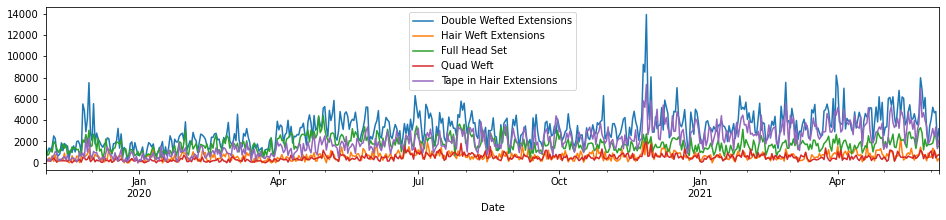

In [141]:
train_set.plot(figs# Step 3. Exploratory Data Analysis

Let's plot the data.ize=(16,3))

# Step 4. Data cleaning and transformation
Before we can start building a model, we need to ensure the data is stationary. We will use the Augmented Dickey-Fuller (ADF) test and the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests to test the series for stationarity.

In [159]:
from statsmodels.tsa.stattools import adfuller, kpss

# test each time series one by one
for x in train_set.columns:
    print(x)
    adf_pval = adfuller(train_set[x], maxlag=10, regression='nc')[1]
    print(f"ADF, p-value: {adf_pval}")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set[x])
    print(f"KPSS, p-value: {kpss_pval}")
    print()

Double Wefted Extensions
ADF, p-value: 0.30254941897058263
KPSS, p-value: 0.01

Hair Weft Extensions
ADF, p-value: 0.23270999997819664
KPSS, p-value: 0.01

Full Head Set
ADF, p-value: 0.34054643455891986
KPSS, p-value: 0.1

Quad Weft
ADF, p-value: 0.33784571619087744
KPSS, p-value: 0.01

Tape in Hair Extensions
ADF, p-value: 0.36054822445370116
KPSS, p-value: 0.01



The results show us that the series are non-stationary. And in this case we will need to trasnform the series through differencing

In [143]:
train_diff = train_set.diff().dropna()
train_diff.head(3)

,Double Wefted Extensions,Hair Weft Extensions,Full Head Set,Quad Weft,Tape in Hair Extensions
Date,,,,,
2019-11-02,208.99,119.98,-733.90,58.99,-358.96
2019-11-03,401.95,269.97,154.97,-84.99,183.98
2019-11-04,-257.96,-180.98,431.94,-9.00,-180.98


In [144]:
for x in train_diff.columns:
    print(x)
    adf_pval = adfuller(train_diff[x], maxlag=10, regression='nc')[1]
    print(f"ADF, p-value: {adf_pval:.3f}")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff[x])
    print(f"KPSS, p-value: {kpss_pval:.3f}")
    print()

Double Wefted Extensions
ADF, p-value: 0.000
KPSS, p-value: 0.100

Hair Weft Extensions
ADF, p-value: 0.000
KPSS, p-value: 0.100

Full Head Set
ADF, p-value: 0.000
KPSS, p-value: 0.100

Quad Weft
ADF, p-value: 0.000
KPSS, p-value: 0.100

Tape in Hair Extensions
ADF, p-value: 0.000
KPSS, p-value: 0.100



All the 5 series have become stationary after the first differencing, according to both tests. So we'll use a differenced training set for building a model and we'll also difference the test data in order to be able to evaluate the model

In [145]:
test_diff = test_set.diff().dropna()

# Step 5. Build models
## 5.1 Baseline
The persistence baseline is generating the previous day's sales as the prediction for this day.

We'll generate a baseline for each subcategory separately and then calculate their average RMSE as well as MAE

In [146]:
rmse_scores = []
for x in test_diff.columns:
    baseline_predictions = test_diff[x].shift()[1:]
    mse = mean_squared_error(test_diff[x][1:], baseline_predictions)
    baseline_rmse = np.sqrt(mse)
    print(f"{x}: {baseline_rmse:.3f}")
    rmse_scores.append(baseline_rmse)

aver = np.array(rmse_scores).mean()
print(f"\nAverage over the subcategories: {aver:.3f}")

Double Wefted Extensions: 2818.961
Hair Weft Extensions: 943.783
Full Head Set: 1108.328
Quad Weft: 583.246
Tape in Hair Extensions: 2197.617

Average over the subcategories: 1530.387


In [147]:
mae_scores = []
for x in test_diff.columns:
    baseline_predictions = test_diff[x].shift()[1:]
    mae = mean_absolute_error(test_diff[x][1:], baseline_predictions)
    baseline_mae = mae
    print(f"{x}: {baseline_mae:.3f}")
    mae_scores.append(baseline_mae)

bbb = np.array(mae_scores).mean()
print(f"\nAverage over the subcategories: {bbb:.3f}")

Double Wefted Extensions: 2196.233
Hair Weft Extensions: 700.973
Full Head Set: 871.793
Quad Weft: 465.879
Tape in Hair Extensions: 1774.887

Average over the subcategories: 1201.953


## 5.2 VAR models
The first step is to select the order of VAR, i.e. the optimal number of lags.

In [148]:
from statsmodels.tsa.vector_ar.var_model import VAR

results = VAR(train_diff).select_order(maxlags=12)
results.summary()

,AIC,BIC,FPE,HQIC
0,64.47,64.50,9.944e+27,64.48
1,63.36,63.59,3.277e+27,63.45
2,62.87,63.28,2.005e+27,63.03
3,62.59,63.20*,1.520e+27,62.83
4,62.47,63.27,1.348e+27,62.78
5,62.30,63.29,1.138e+27,62.69
6,62.11,63.29,9.450e+26,62.57*
7,62.07,63.44,9.073e+26,62.61
8,62.04*,63.60,8.775e+26*,62.65
9,62.08,63.83,9.121e+26,62.76


Two criteria suggest the lag of 8,whereas one suggests 3 lags and the last one suggest 6 lags. We will use 3 lags since there is no difference in the results obtained.

In [149]:
var_model = VAR(train_diff).fit(3)

In [150]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Jan, 2022
Time:                     21:56:27
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    63.1407
Nobs:                     580.000    HQIC:                   62.7736
Log likelihood:          -22171.2    FPE:                1.44661e+27
AIC:                      62.5389    Det(Omega_mle):     1.26258e+27
--------------------------------------------------------------------
Results for equation Double Wefted Extensions
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               5.072662        50.191325            0.101           0.919
L1.Double Wefted Extensions        -0.630868         0.051470          -12.257  

# Step 6. Evaluate the model on the test set
We'll use the same evaluation setup as with the ARIMA model: we'll make one-step-ahead forecasts, and we will re-train the model on training data plus any test data that has already been used for evaluation.

In [151]:
# buffers keeping training + previously seen test data
history = train_diff.values
predictions = []

# for each test observation, take the first 200 for convenience
for i, test_obs in enumerate(test_diff.values):
    
    # build a model using the current buffers
    model = VAR(history).fit(8)
        
    # forecast the value for the test instance, supplying corresponding exogenous variables 
    yhat = model.forecast(model.y, steps=1)
    
    # remember the forecasted value
    predictions.append(yhat[0])
    
    # update the buffers for the endogenous and exogenous variables
    history = np.append(history, test_obs.reshape(1, -1), axis=0)

predictions = pd.DataFrame(predictions, columns=test_diff.columns, index=test_diff.index)

predictions.head(3)

,Double Wefted Extensions,Hair Weft Extensions,Full Head Set,Quad Weft,Tape in Hair Extensions
Date,,,,,
2021-06-08,366.687834,267.707593,369.044676,-33.320813,255.302218
2021-06-09,66.288257,213.041756,221.033161,157.147445,650.913600
2021-06-10,651.640753,187.989357,449.515929,308.455237,-473.789734


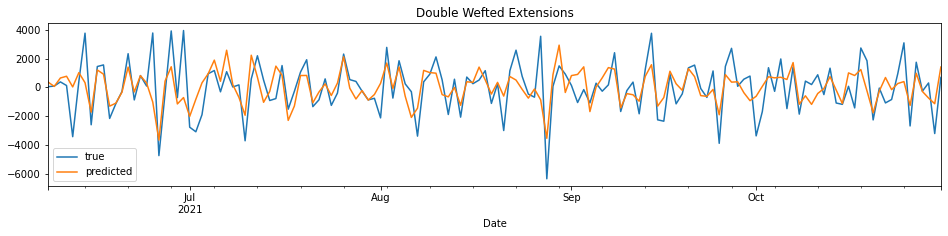

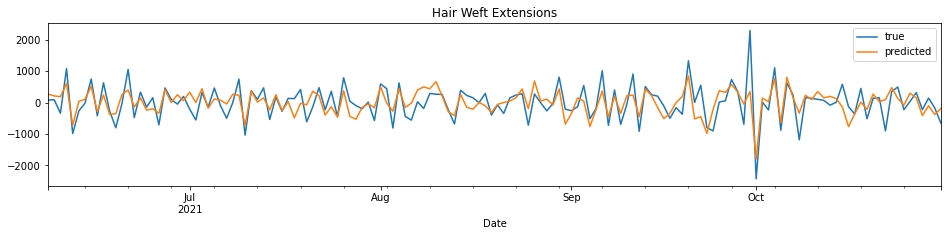

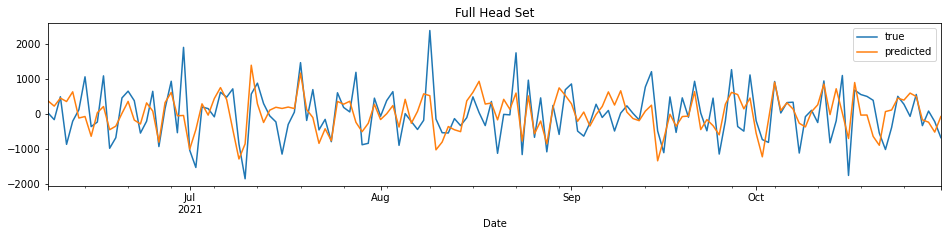

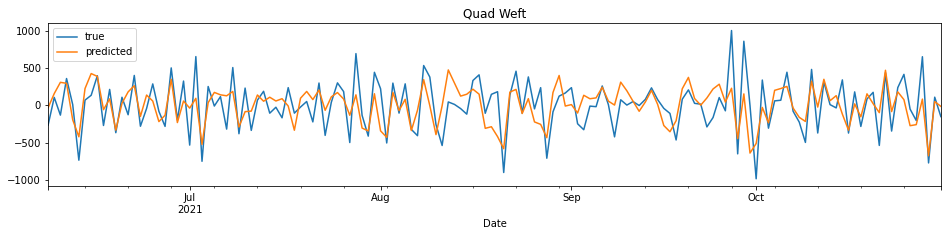

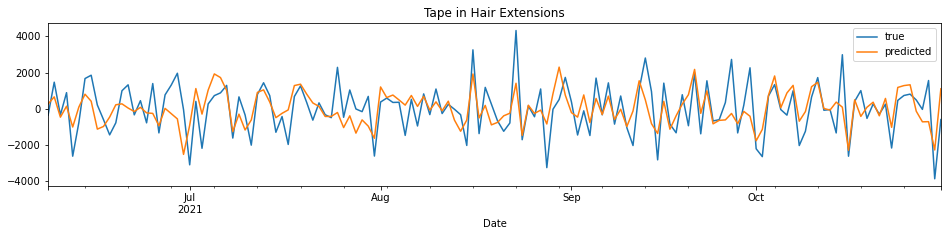

In [152]:
for x in test_diff.columns:
    pd.DataFrame({"true": test_diff[x][:200], 
                  "predicted": predictions[x][:200]}).plot(figsize=(16, 3), title=x)

Finally, let's calculate the RMSE and MAE scores within each subcategory and the average RMSE across the subcategories.

In [153]:
aver = []
for x in test_diff.columns:
    rmse = np.sqrt(mean_squared_error(test_diff[x], predictions[x]))
    print(x)
    print(f"RMSE: {rmse:.3f}")
    print()
    aver.append(rmse)

print(f"Average over subcategories: {np.array(aver).mean():.3f}")

Double Wefted Extensions
RMSE: 1387.084

Hair Weft Extensions
RMSE: 393.885

Full Head Set
RMSE: 605.719

Quad Weft
RMSE: 268.210

Tape in Hair Extensions
RMSE: 1121.773

Average over subcategories: 755.334


In [154]:
bbb = []
for x in test_diff.columns:
    mae = mean_absolute_error(test_diff[x], predictions[x])
    print(x)
    print(f"MAE: {mae:.3f}")
    print()
    bbb.append(mae)

print(f"Average over subcategories: {np.array(bbb).mean():.3f}")

Double Wefted Extensions
MAE: 1050.892

Hair Weft Extensions
MAE: 306.498

Full Head Set
MAE: 480.994

Quad Weft
MAE: 215.900

Tape in Hair Extensions
MAE: 877.133

Average over subcategories: 586.284


Let's compare these results to those achieved by the baseline method. We'll put them into a dataframe, for convenience:

In [155]:
baseline_rmse = {
    "Double Wefted Extensions": 2818.961,
    "Hair Weft Extensions": 943.783,
    "Full Head Set": 1108.328,
    "Quad Weft": 583.246,
    "Tape in Hair Extensions": 2197.617,
    "Average": 1530.387
}

var_rmse = {
    "Double Wefted Extensions": 1387.084,
    "Hair Weft Extensions": 393.885,
    "Full Head Set": 605.719,
    "Quad Weft": 268.210,
    "Tape in Hair Extensions": 1121.773,
    "Average":755.334
}

scores_df = pd.DataFrame([baseline_rmse, var_rmse]).transpose()
scores_df.columns = ["Baseline", "VAR"]
scores_df

,Baseline,VAR
Double Wefted Extensions,2818.961,1387.084
Hair Weft Extensions,943.783,393.885
Full Head Set,1108.328,605.719
Quad Weft,583.246,268.210
Tape in Hair Extensions,2197.617,1121.773
Average,1530.387,755.334


Add a column showing percentage of RMSE reduction in VAR compared to the baseline:

In [156]:
scores_df["% reduction"] = 100*(scores_df["Baseline"]-scores_df["VAR"])/scores_df["Baseline"]
scores_df

,Baseline,VAR,% reduction
Double Wefted Extensions,2818.961,1387.084,50.794495
Hair Weft Extensions,943.783,393.885,58.265300
Full Head Set,1108.328,605.719,45.348399
Quad Weft,583.246,268.210,54.014258
Tape in Hair Extensions,2197.617,1121.773,48.955027
Average,1530.387,755.334,50.644249


In [157]:
baseline_mae = {
    "Double Wefted Extensions": 2196.233,
    "Hair Weft Extensions": 700.973,
    "Full Head Set": 871.793,
    "Quad Weft": 465.879,
    "Tape in Hair Extensions": 1774.887,
    "Average": 1201.953
}

var_mae = {
    "Double Wefted Extensions": 1050.892,
    "Hair Weft Extensions": 306.498,
    "Full Head Set": 480.994,
    "Quad Weft": 215.900,
    "Tape in Hair Extensions": 877.133,
    "Average":586.284
}

new_scores_df = pd.DataFrame([baseline_mae, var_mae]).transpose()
new_scores_df.columns = ["Baseline", "VAR"]
new_scores_df

,Baseline,VAR
Double Wefted Extensions,2196.233,1050.892
Hair Weft Extensions,700.973,306.498
Full Head Set,871.793,480.994
Quad Weft,465.879,215.900
Tape in Hair Extensions,1774.887,877.133
Average,1201.953,586.284


Same process will be applied for MAE as well

In [158]:
new_scores_df["% reduction"] = 100*(new_scores_df["Baseline"]-new_scores_df["VAR"])/new_scores_df["Baseline"]
new_scores_df

,Baseline,VAR,% reduction
Double Wefted Extensions,2196.233,1050.892,52.150250
Hair Weft Extensions,700.973,306.498,56.275349
Full Head Set,871.793,480.994,44.827040
Quad Weft,465.879,215.900,53.657495
Tape in Hair Extensions,1774.887,877.133,50.580910
Average,1201.953,586.284,51.222386


# Conclusion
The VAR model reduced the RMSE rate by 50.6% overall, and by between 45% and 58% in specific subcategories. Whereas for MAE, the VAR model reduce the rate by 51.2% overall, and by between 44% and 56% in case of specific subcategories.